# Question 5 A first Gibbs sampler

Want to estimate posterior

$$
p(s_1, s_2|y=1)
$$

And we know that $p(y=1)$ = $p(t>0)$.

so

$$
p(s_1, s_2|t>0)
$$

# Project in APML

Contributors:

- Bjørn Christian Weinbach
- Emil
- Markus

In [3]:
import numpy as np
import scipy.stats
import matplotlib.pyplot
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Save figures - Set to true if you want to reproduce figures.
save = False

def gibbsSampler(L, mu_s, sigma_s, burn=0):
    L = L

    # Initial Chain of values
    s1 = np.zeros(L)
    s2 = np.zeros(L)
    t = np.zeros(L)
    s1[0] = mu_s[0]
    s2[0] = mu_s[1]
    t[0] = 1

    # Hyperparameters
    sigma_ts = (25/3)**2

    def corr1(sigmaa, sigmaba, mua, xb): 
        A = np.array([1, -1])
        sigmaab = np.linalg.inv(np.linalg.inv(sigmaa) + np.outer(A.T, A)*sigmaba**-1)
        muab = sigmaab@(np.linalg.inv(sigmaa)@mua + A.T*sigmaba**-1*xb)
        return sigmaab, muab

    for l in range(L-1):
        # Sample S
        sigma_st, mu_st = corr1(sigma_s, sigma_ts, mu_s, t[l])
        s1[l+1], s2[l+1] = scipy.stats.multivariate_normal.rvs(mean=mu_st, cov=sigma_st)

        # Sample T
        smean = s1[l] - s2[l]
        a_scaled, b_scaled = (0 - (smean)) / sigma_ts, (np.inf - (smean)) / sigma_ts
        t[l+1] = scipy.stats.truncnorm.rvs(a_scaled, b_scaled, loc=smean, scale=np.sqrt(sigma_ts))
    return s1[burn:], s2[burn:], t[burn:]

In [4]:
# Samples
L = 1000
burn = 0
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

In [5]:
experiment = pd.DataFrame(
    {
        "s1": s1,
        "s2": s2,
        "t": t
    }
)

30.456829516674354

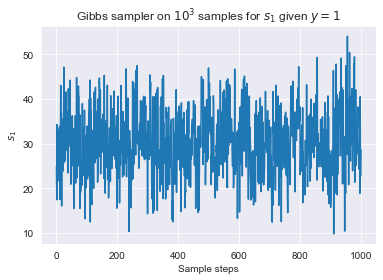

In [6]:
plt.plot(s1)
plt.title("Gibbs sampler on $10^3$ samples for $s_1$ given $y=1$")
plt.ylabel("$s_1$")
plt.xlabel("Sample steps")
if(save):
    plt.savefig("s1traceplotwithoutburnin.png")
np.mean(s1)

30.456829516674354

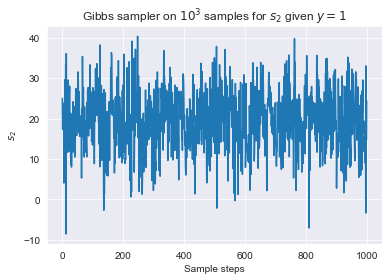

In [7]:
plt.plot(s2)
plt.title("Gibbs sampler on $10^3$ samples for $s_2$ given $y=1$")
plt.ylabel("$s_2$")
plt.xlabel("Sample steps")
if(save):
    plt.savefig("s2traceplotwithoutburnin.png")
np.mean(s1)

<Figure size 1080x1080 with 0 Axes>

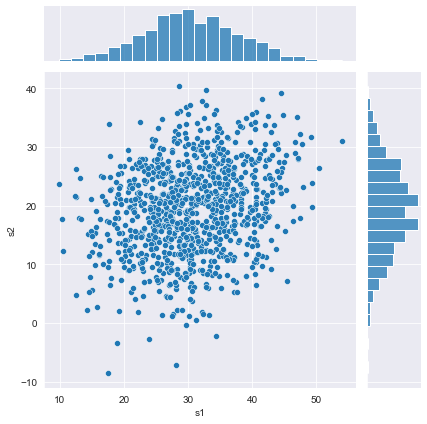

In [8]:
plt.figure(figsize=(15, 15))
sns.set_style("darkgrid")
sns.jointplot(data=experiment, x="s1", y="s2")

if(save):
    plt.savefig("s1s2jointplot.png")

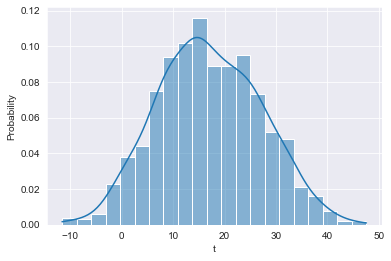

In [9]:
sns.histplot(experiment, x="t", kde=True, fill=True, stat='probability')
if(save):
    plt.savefig("thistogram.png")

### Trueskill representation of the skills

We will transform the samples into a gaussian. We will do this by approximating it as a gaussian.

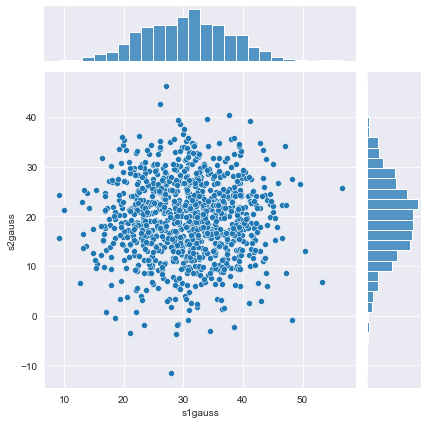

In [10]:
def gaussianApprox(samples):
    return scipy.stats.norm(loc=np.mean(samples), scale=np.std(samples))

s1gauss = gaussianApprox(experiment.s1)
s2gauss = gaussianApprox(experiment.s2)

approximation = pd.DataFrame(
    {
        "s1gauss" : s1gauss.rvs(L),
        "s2gauss" : s2gauss.rvs(L),
    }
)

sns.jointplot(data=approximation, x="s1gauss", y="s2gauss")

if(save):
    plt.savefig("GaussApproxJointPlot.png")

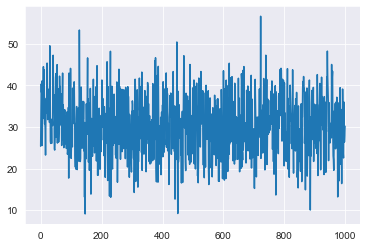

In [11]:
plt.plot(approximation.s1gauss)
if(save):
    plt.savefig("s1GaussApproxTraceplot.png")

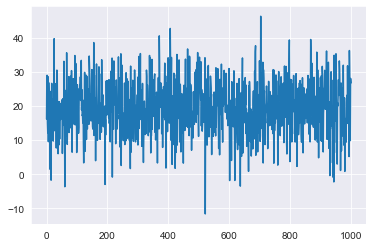

In [12]:
plt.plot(approximation.s2gauss)
if(save):
    plt.savefig("s1GaussApproxTraceplot.png")

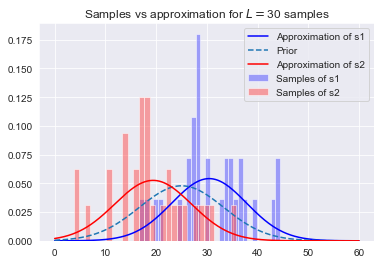

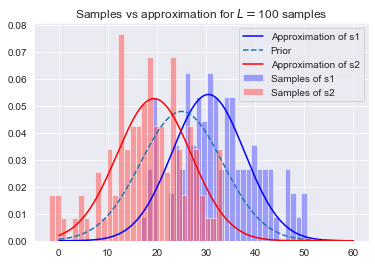

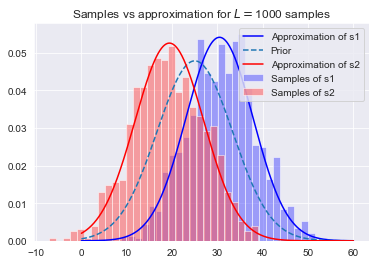

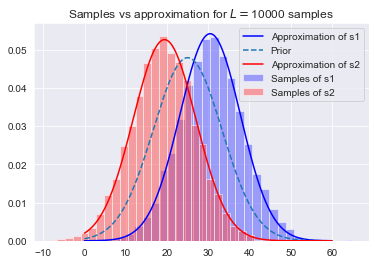

In [15]:
samplesize = [30, 100, 1000, 10000]
burn = 50
for L in samplesize:
    # Priors
    sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
    mu_s = np.array([25, 25])

    # Sample
    s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
    x = np.linspace(0, 60, 1000)
    plt.hist(s1, bins=30, alpha=0.5, density=True, label='Samples of s1', color=(0.3,0.3,1))
    plt.hist(s2, bins=30, alpha=0.5, density=True, label='Samples of s2', color=(1,0.3,0.3))
    plt.plot(x, s1gauss.pdf(x),'b', label='Approximation of s1')
    plt.plot(x, scipy.stats.norm.pdf(x, 25, 25/3), '--', label = 'Prior')
    plt.plot(x, s2gauss.pdf(x),'r', label='Approximation of s2')
    plt.legend()
    titlestring = "Samples vs approximation for $L =$" + str(L) + " samples"
    filename = "samplevsdist" + str(L) + ".png"
    plt.title(titlestring)
    plt.savefig(filename)
    plt.show()

### Compare priors with posteriors given thet $p(s|y=1)$

Our prior stated:

$$
p(s_1) = \sim N(s_1; 25, (25/3)^2)
$$

$$
p(s_2) = \sim N(s_2; 25, (25/3)^2)
$$

Empirically we have:

In [ ]:
np.mean(s1)

32.58624150787246

In [ ]:
np.var(s1)

63.63093356140534

In [ ]:
np.mean(s2)

19.58380771718879

In [ ]:
np.var(s2)

69.6143606053281

# Question 6

Use ADF with Gibbs sampling to process the matches in the SerieA dataset and estimatethe skill of all the teams in the dataset 

In [ ]:
# Read the data
data = 'datasets/SerieA.csv'
shuffle = False
serieA = pd.read_csv(data)
cleaned = serieA[serieA['score1'] != serieA['score2']]
cleaned["pred"] = 0
cleaned['true'] = np.where(cleaned['score1'] > cleaned['score2'], 1, -1)
if(shuffle):
    cleaned = cleaned.sample(frac=1).reset_index(drop=True)
cleaned

<ipython-input-31-a6bdca6b39a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned["pred"] = 0
<ipython-input-31-a6bdca6b39a8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['true'] = np.where(cleaned['score1'] > cleaned['score2'], 1, -1)


,yyyy-mm-dd,HH:MM,team1,team2,score1,score2,pred,true
0,2018-08-18,18:00,Chievo,Juventus,2,3,0,-1
1,2018-08-18,20:30,Lazio,Napoli,1,2,0,-1
2,2018-08-19,18:00,Torino,Roma,0,1,0,-1
3,2018-08-19,20:30,Sassuolo,Inter,1,0,0,1
5,2018-08-19,20:30,Empoli,Cagliari,2,0,0,1
...,...,...,...,...,...,...,...,...
374,2019-05-26,20:30,Spal,Milan,2,3,0,-1
375,2019-05-26,20:30,Roma,Parma,2,1,0,1
376,2019-05-26,20:30,Inter,Empoli,2,1,0,1
378,2019-05-26,20:30,Cagliari,Udinese,1,2,0,-1


## Add priors to all teams

In [ ]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)
# Find teams names from dataframe
teams = cleaned.team1.unique()

# Make dictionary of priors
distributions = {}

# Give all same prior
for team in teams:
    distributions[team] = s1gauss

## Update distributions based on data

In [ ]:
# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    else:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss


## Create a ranking table that ranks based on trueskill's conservative skill with $k=3$

In [ ]:
team, mu, std, cs = [], [], [], []
k = 3

for key, dist in distributions.items():
    team.append(key)
    mu.append(dist.mean())
    std.append(dist.std())
    cs.append(dist.mean() - k*dist.std())

results = pd.DataFrame(
    {
        'Team': team,
        'Conservative Skill': cs
    }
)
results = results.sort_values('Conservative Skill', ascending=False).reset_index(drop=True)
print(results.to_latex())

\begin{tabular}{llr}
\toprule
{} &        Team &  Conservative Skill \\
\midrule
0  &    Juventus &           60.406883 \\
1  &      Napoli &           43.969245 \\
2  &       Milan &           40.458317 \\
3  &       Inter &           37.840559 \\
4  &        Roma &           32.919107 \\
5  &      Torino &           32.892420 \\
6  &  Fiorentina &           30.767102 \\
7  &       Lazio &           28.939552 \\
8  &    Atalanta &           28.882288 \\
9  &   Sampdoria &           28.479135 \\
10 &     Udinese &           23.170194 \\
11 &       Genoa &           20.452003 \\
12 &    Sassuolo &           20.367028 \\
13 &        Spal &           19.008137 \\
14 &       Parma &           16.824631 \\
15 &    Cagliari &           15.583702 \\
16 &     Bologna &           12.271852 \\
17 &      Empoli &            6.714022 \\
18 &   Frosinone &            2.030894 \\
19 &      Chievo &           -8.440686 \\
\bottomrule
\end{tabular}



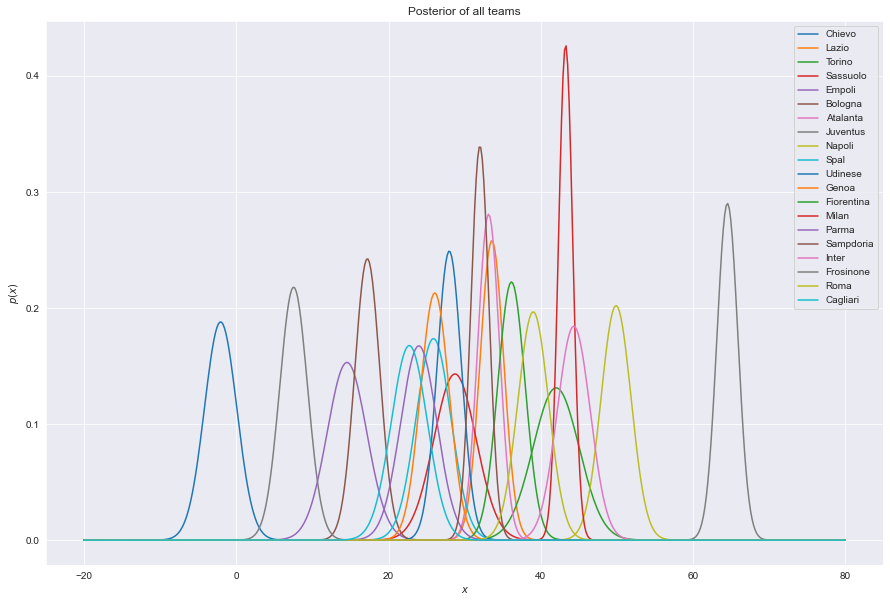

In [ ]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all teams")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
if(save):
    plt.savefig("posteriors.png")

## Q7 Using the model for predictions



In [ ]:
def winningPrediction(player1, player2, k=3):
    m1, m2 = distributions[player1].mean(), distributions[player2].mean()
    s1, s2 = distributions[player1].std(), distributions[player2].std()
    cs1, cs2 = m1 - k*s1, m2 - k*s2
    if(cs1 >= cs2):
      return 1
    else:
      return -1

## Reset Priors

In [ ]:
# hyperparameters
L = 100
burn = 50

# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)


# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)
teams = cleaned.team1.unique()

# Make dictionary of priors
distributions = {}

# Give all same prior
for team in teams:
    distributions[team] = s1gauss

## Calculate posterior and predict one step ahead

In [ ]:
pred = []

# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        pred.append(winningPrediction(row['team1'], row['team2']))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    else:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        pred.append(winningPrediction(row['team1'], row['team2']))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss

cleaned["pred"] = pred

<ipython-input-38-1e3a6a4354eb>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned["pred"] = pred


In [ ]:
true_values = np.array(cleaned.true)
predictions = np.array(cleaned.pred)
np.sum(true_values == predictions) / len(true_values)

0.6433823529411765

# Question 10. Tennis datasets

I have downloaded the tennis dataset from [ATP Wourld Tour tennis data](https://datahub.io/sports-data/atp-world-tour-tennis-data).
Let us explore this data and clean it up.

In [ ]:
tennis = pd.read_csv('datasets/tennis.csv')

## Explore the features

In [ ]:
tennis.columns

Index(['tourney_year_id', 'tourney_order', 'tourney_slug',
       'tourney_url_suffix', 'tourney_round_name', 'round_order',
       'match_order', 'winner_name', 'winner_player_id', 'winner_slug',
       'loser_name', 'loser_player_id', 'loser_slug', 'winner_seed',
       'loser_seed', 'match_score_tiebreaks', 'winner_sets_won',
       'loser_sets_won', 'winner_games_won', 'loser_games_won',
       'winner_tiebreaks_won', 'loser_tiebreaks_won', 'match_id',
       'match_stats_url_suffix'],
      dtype='object')

## Data Cleaning

In [ ]:
# Hyperparameters
N = 15      # No of top winners we want to include
Y = 2015    # Start year (inclusive)

# Extract relevant features
features = ['tourney_year_id', 'winner_name', 'loser_name']
tennis = tennis[features]

if(tennis.tourney_year_id.dtype == 'object'):
    # convert to years  
    tennis['tourney_year_id'] = tennis['tourney_year_id'].apply(lambda x : x.split('-')[0])
    tennis['tourney_year_id'] = tennis['tourney_year_id'].astype(int)

# Extract the latest years
tennis = tennis[tennis.tourney_year_id >= Y]

# Extract the 15 players who won the most matches
winners = tennis.winner_name.value_counts()[:N].index.to_list()

# Extract matches where these players are playing eachother
topplayers = tennis[tennis.winner_name.isin(winners) & tennis.loser_name.isin(winners)]

# Add prediction column
topplayers["pred"] = 0

<ipython-input-42-e91cd8c8299a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topplayers["pred"] = 0


## Run Gibbs sampler on data

In [ ]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)
# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)

# Make dictionary of priors
distributions = {}

# Give all same prior
for player in winners:
    distributions[player] = s1gauss

In [ ]:
pred = []

# Update priors based on data
for index, row in topplayers.iterrows():
    pred.append(winningPrediction(row['winner_name'], row['loser_name']))
    mu1 = distributions[row['winner_name']].mean()
    mu2 = distributions[row['loser_name']].mean()
    s1 = distributions[row['winner_name']].var()
    s2 = distributions[row['loser_name']].var()

    mu_s = np.array([mu1, mu2], np.float64)
    sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

    # Sample
    s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
    s1gauss = gaussianApprox(s1)
    s2gauss = gaussianApprox(s2)
    distributions[row['winner_name']] = s1gauss
    distributions[row['loser_name']] = s2gauss

topplayers["pred"] = pred

<ipython-input-44-c93c26998faa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topplayers["pred"] = pred


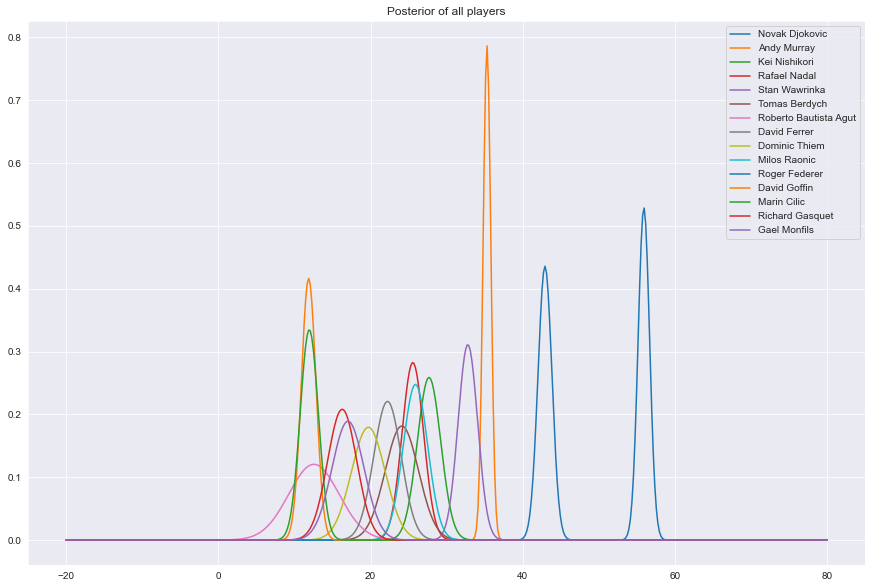

In [ ]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all players")
if(save):
    plt.savefig("posteriors.png")

In [ ]:
team, cs = [], []
k = 3

for key, dist in distributions.items():
    team.append(key)
    cs.append(dist.mean() - k*dist.std())

results = pd.DataFrame(
    {
        'Team': team,
        'Conservative Skill': cs
    }
)
results = results.sort_values('Conservative Skill', ascending=False).reset_index(drop=True)
print(results.to_latex())

\begin{tabular}{llr}
\toprule
{} &                   Team &  Conservative Skill \\
\midrule
0  &         Novak Djokovic &           53.650883 \\
1  &          Roger Federer &           40.169981 \\
2  &            Andy Murray &           33.774333 \\
3  &          Stan Wawrinka &           28.933843 \\
4  &          Kei Nishikori &           23.056681 \\
5  &           Rafael Nadal &           21.317398 \\
6  &           Milos Raonic &           21.070978 \\
7  &          Tomas Berdych &           17.513976 \\
8  &           David Ferrer &           16.798929 \\
9  &          Dominic Thiem &           13.036015 \\
10 &           Gael Monfils &           10.710743 \\
11 &        Richard Gasquet &           10.516335 \\
12 &           David Goffin &            8.983299 \\
13 &            Marin Cilic &            8.367595 \\
14 &  Roberto Bautista Agut &            2.625005 \\
\bottomrule
\end{tabular}



In [ ]:
predictions = np.array(topplayers['pred'])

print("Accuray: " + str(np.sum(predictions==1) / len(predictions)))

Accuray: 0.730909090909091


## Q9

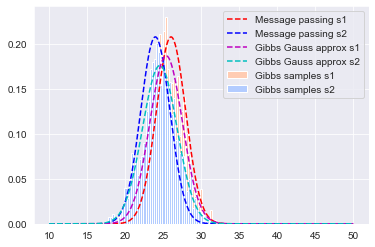

In [16]:
from scipy.stats import truncnorm, norm

def MultiplyGauss(m1, s1, m2, s2):
    #Multiplication of two Normal distributions
    #N(m, s) = N(m1, s1)*N(m2, s2)
    
    s = s1*s2/(s1 + s2)
    m = (m1*s2 + m2*s1)/(s1 + s2)
    return m, s

def DivideGauss(m1, s1, m2, s2):
    #Division of two Normal distributions
    #N(m, s) = N(m1, s1)/N(m2, s2)
    
    m, s = MultiplyGauss(m1, s1, m2, -s2)
    return m, s

def TruncGauss(m0, s0, a, b):
    #Approxiamtion of the truncated Gaussian:
    #N(m0, s0) on the interval [a, b] 
    sd = np.sqrt(s0)
    a_scaled, b_scaled = (a - m0)/sd, (b - m0)/sd
    m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=sd)
    s = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=sd)
    return m, s

#Hyperparameters from earlier
m_s1 = 25 #Mean of s1
s_s1 = 5 #Variance of s1
m_s2 = 25 #Mean of s2
s_s2 = 5 #Variance of s2
s_ts = 5 #Variance of t|s
y = 1 #Message from y node

def MessagePassing(m_s1, s_s1, m_s2, s_s2, s_ts):
    #Messages from f1 -> s1 -> f3 -> t, f2 -> s2 -> f3 -> t
    #Maginalize t (Lecture 2)
    mu3m = m_s1 - m_s2
    mu3s = s_s1 + s_s2 + s_ts

    #Moment match of the marginal of t
    if y == 1:
        a, b = 0, 1000 #1000 big enough
    else: #-1 is the only other option
        a, b = -1000, 0
    mu4m, mu4s = TruncGauss(mu3m, mu3s, a, b)

    #Message backwards from node t to f3
    mu5m, mu5s = DivideGauss(mu4m, mu4s, mu3m, mu3s)

    #Messages from f3 to node s1 and s2
    mu6m = m_s2 + mu5m #s1
    mu6s = s_s2 + mu5s + s_ts
    mu7m = m_s1 - mu5m #s2
    mu7s = s_s1 + mu5s + s_ts    

    #Marginalize s1, s2
    pm_s1, ps_s1 = MultiplyGauss(mu6m, mu6s, m_s1, s_s1) #s1
    pm_s2, ps_s2 = MultiplyGauss(mu7m, mu7s, m_s2, s_s2) #s2

    return pm_s1, ps_s1, pm_s2, ps_s2


pm_s1, ps_s1, pm_s2, ps_s2 = MessagePassing(m_s1, s_s1, m_s2, s_s2, s_ts)

L = 1000
burn = 50
x = np.linspace(10, 50, 500)

#PDF
s1_pdf = norm.pdf(x, pm_s1, np.sqrt(ps_s1))
s2_pdf = norm.pdf(x, pm_s2, np.sqrt(ps_s2))

# Priors
sigma_s = np.array([[s_s1, 0], [0, s_s2]])
mu_s = np.array([m_s1, m_s2])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)

#Plot
plt.plot(x,s1_pdf,'--r',label='Message passing s1')
plt.plot(x,s2_pdf,'--b',label='Message passing s2')
plt.plot(x,s1gauss.pdf(x),'--m',label='Gibbs Gauss approx s1')
plt.plot(x,s2gauss.pdf(x),'--c',label='Gibbs Gauss approx s2')
plt.hist(s1, bins=50, density=True, label='Gibbs samples s1',color=(1,0.8,0.7))
plt.hist(s2, bins=50, density=True, label='Gibbs samples s2',color=(0.7,0.8,1))
plt.legend()
plt.savefig('Gibbs_vs_MP.png')
plt.show()

## Q11 Extensions of model

Include draws:

In [ ]:
def winningPrediction(player1, player2, k=3, drawprob=0.5):
    m1, m2 = distributions[player1].mean(), distributions[player2].mean()
    s1, s2 = distributions[player1].std(), distributions[player2].std()

    # Draw update
    beta = ((s1+s2)/4)**2
    margin = np.abs(mu1 - mu2)
    epsilon = scipy.stats.norm.ppf((drawprob + 1)/2)*np.sqrt(2)*beta

    # Check if inside draw margin.
    if(margin < epsilon):
      return 0

    cs1, cs2 = m1 - k*s1, m2 - k*s2
    if(cs1 >= cs2):
      return 1
    else:
      return -1

In [ ]:
# Read the data
data = 'datasets/SerieA.csv'
shuffle = False
serieA = pd.read_csv(data)
cleaned = serieA
cleaned["pred"] = 0
cleaned['true'] = np.sign(cleaned['score1'] - cleaned['score2'])
if(shuffle):
    cleaned = cleaned.sample(frac=1).reset_index(drop=True)
cleaned

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2,pred,true
0,2018-08-18,18:00,Chievo,Juventus,2,3,0,-1
1,2018-08-18,20:30,Lazio,Napoli,1,2,0,-1
2,2018-08-19,18:00,Torino,Roma,0,1,0,-1
3,2018-08-19,20:30,Sassuolo,Inter,1,0,0,1
4,2018-08-19,20:30,Parma,Udinese,2,2,0,0
...,...,...,...,...,...,...,...,...
375,2019-05-26,20:30,Roma,Parma,2,1,0,1
376,2019-05-26,20:30,Inter,Empoli,2,1,0,1
377,2019-05-26,20:30,Fiorentina,Genoa,0,0,0,0
378,2019-05-26,20:30,Cagliari,Udinese,1,2,0,-1


In [ ]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)


# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)

# Make dictionary of priors
distributions = {}

# Give all same prior
for player in teams:
    distributions[player] = s1gauss

In [ ]:
pred = []
drawprob = 0.5

# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    elif row['score1'] < row['score2']:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss
    else:
        # We have a draw
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()

        # NB: Standard deviation in this case
        s1 = distributions[row['team1']].std()
        s2 = distributions[row['team2']].std()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        # Draw update
        beta = ((s1+s2)/4)**2
        margin = np.abs(mu1 - mu2)
        epsilon = scipy.stats.norm.ppf((drawprob + 1)/2)*np.sqrt(2)*beta

        # Check if inside draw margin.
        if(margin < epsilon):
            if(mu1 > mu2):
                # Punish player 1
                newmu1 = mu1 - margin/s1
                distributions[row['team1']] = scipy.stats.norm(loc=newmu1, scale=s1)
                # Reward player 2
                newmu2 = mu2 + margin/s2
                distributions[row['team1']] = scipy.stats.norm(loc=newmu2, scale=s2)
            if(mu2 > mu1):
                # Reward player 1
                newmu1 = mu1 + margin/s1
                distributions[row['team1']] = scipy.stats.norm(loc=newmu1, scale=s1)
                # Punish player 2
                newmu2 = mu2 - margin/s2
                distributions[row['team1']] = scipy.stats.norm(loc=newmu2, scale=s2)

cleaned["pred"] = pred

In [ ]:
cleaned.pred.value_counts()

-1    152
 1    144
 0     84
Name: pred, dtype: int64

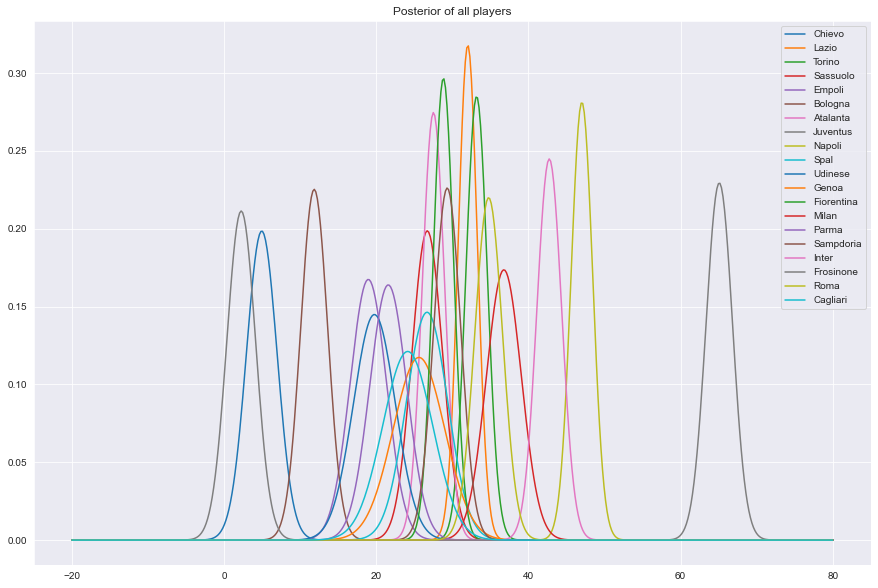

In [ ]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all players")
if(save):
    plt.savefig("posteriors.png")

true_values = np.array(cleaned.true)
predictions = np.array(cleaned.pred)

conf = confusion_matrix(true_values, predictions)

In [ ]:
def recall(conf, classname):
    results = {}
    for key, value in classname.items():
        results[key] = conf[value, value] / np.sum(conf[value, :])
    return results

def precision(conf, classname):
    results = {}
    for key, value in classname.items():
        results[key] = conf[value, value] / np.sum(conf[:, value])
    return results

def f1(conf, classname):
    rec = recall(conf, classname)
    prec = precision(conf, classname)
    results = {}
    for key in rec:
        results[key] = (2*prec[key]*rec[key]) / (prec[key]+rec[key])
    return results

classname = {
    "Loss": 0,
    "Draw": 1,
    "Win": 2
} 

recall(conf, classname)

{'Loss': 0.6415094339622641, 'Draw': 0.2962962962962963, 'Win': 0.5}

In [ ]:
precision(conf, classname)

{'Loss': 0.4473684210526316,
 'Draw': 0.38095238095238093,
 'Win': 0.5763888888888888}

In [ ]:
f1(conf, classname)

{'Loss': 0.5271317829457365,
 'Draw': 0.3333333333333333,
 'Win': 0.5354838709677419}